# 改进Transformer+Informer支持多变量对少变量预测

## 训练与测试

### 导入库函数

In [13]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


### 创建Argparse

In [2]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
# args.data = 'ETTh1' # data
args.data = 'beartem0529' # data
args.root_path = './data/ETT' # root path of data file
args.data_path = 'data_align_tpt_0206gbk_final.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '动量轮FMW2轴承温度' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.train_time_range = ['2015-08-01 01:00:00','2016-07-31 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-07-31 00:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00:00','2016-05-24 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-05-31 00:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00:00','2016-05-19 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-05-31 00:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00:00','2016-02-01 01:00:00'] # 训练时间范围
args.valid_time_range = ['2016-02-01 02:00:00','2016-03-01 01:00:00'] # 验证时间范围
args.test_time_range = ['2016-02-01 01:00:00','2016-05-31 07:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00','2016-02-01 01:00'] # 训练时间范围（去除秒格式也一样可以）
args.valid_time_range = ['2016-02-01 02:00:00','2016-03-01 01:00:00'] # 验证时间范围
args.test_time_range = ['2016-02-01 01:00:00','2016-05-31 07:00:00'] # 测试时间范围

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 11 # encoder input size
args.dec_in = 11 # decoder input size
args.c_out = 11 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.s_layers = '3,2,1' # num of encoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.inverse = True
args.des = 'train'
args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1' # 'type1','type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 20
args.patience = 20
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0'


### cuda调用

In [3]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

### 任务指定

In [4]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'beartem0529':{'data':'data_tpt_0206gbk_final_toplist.csv','T':'动量轮FMW2轴承温度','M':[11,11,11],'S':[1,1,1],'MS':[11,11,1]}
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [5]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [6]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'beartem0529', 'root_path': './data/ETT', 'data_path': 'data_tpt_0206gbk_final_toplist.csv', 'features': 'M', 'target': '动量轮FMW2轴承温度', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'train_time_range': ['2015-08-01 01:00', '2016-02-01 01:00'], 'valid_time_range': ['2016-02-01 02:00:00', '2016-03-01 01:00:00'], 'test_time_range': ['2016-02-01 01:00:00', '2016-05-31 07:00:00'], 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 11, 'dec_in': 11, 'c_out': 11, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 2, 's_layers': '3,2,1', 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'inverse': True, 'des': 'train', 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 20, 'patience': 20, 'use_gpu': True, 'gpu': 0, 'use_m

### 调用Informer函数

In [7]:
Exp = Exp_Informer

### 网络训练

In [8]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_beartem0529_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_train_0>>>>>>>>>>>>>>>>>>>>>>>>>>
	iters: 100, epoch: 1 | loss: 0.7718557
	speed: 0.1037s/iter; left time: 267.6078s
Epoch: 1 cost time: 12.898330211639404
Epoch: 1, Steps: 134 | Train Loss: 1.5574671 Vali Loss: 0.9264622 Test Loss: 3.9011199
Validation loss decreased (inf --> 0.926462).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.4105374
	speed: 0.1319s/iter; left time: 322.6952s
Epoch: 2 cost time: 9.897438287734985
Epoch: 2, Steps: 134 | Train Loss: 0.5675364 Vali Loss: 0.7568911 Test Loss: 3.5365298
Validation loss decreased (0.926462 --> 0.756891).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.4922473
	speed: 0.1329s/iter; left time: 307.2997s
Epoch: 3 cost time: 9.974699020385742
Epoch: 3, Steps: 134 | Train Loss: 0.4831806 Vali Loss: 0.7744086 Test Loss: 3.5664926
Valid

### 测试集预测结果

In [9]:
# 时间索引

df_time = pd.read_csv(os.path.join(args.root_path,args.data_path),encoding='gbk')
df_time = pd.to_datetime(df_time['date'], format='%Y-%m-%d %H:%M:%S').to_list()
train_time_range = args.train_time_range # 训练时间范围
valid_time_range = args.valid_time_range # 验证时间范围
test_time_range = args.test_time_range # 测试时间范围

border1s = [df_time.index(pd.to_datetime(train_time_range[0])), df_time.index(pd.to_datetime(valid_time_range[0])) - args.seq_len, df_time.index(pd.to_datetime(test_time_range[0])) + args.pred_len]
# 训练集、验证集、测试集开始时间
border2s = [df_time.index(pd.to_datetime(train_time_range[1])), df_time.index(pd.to_datetime(valid_time_range[1])), df_time.index(pd.to_datetime(test_time_range[1]))]
# 训练集、验证集、测试集结束时间

(2848, 24, 11) (2848, 24, 11)
[[11.629625 11.53488  11.534706 ... 14.568187 14.362283 14.046993]]


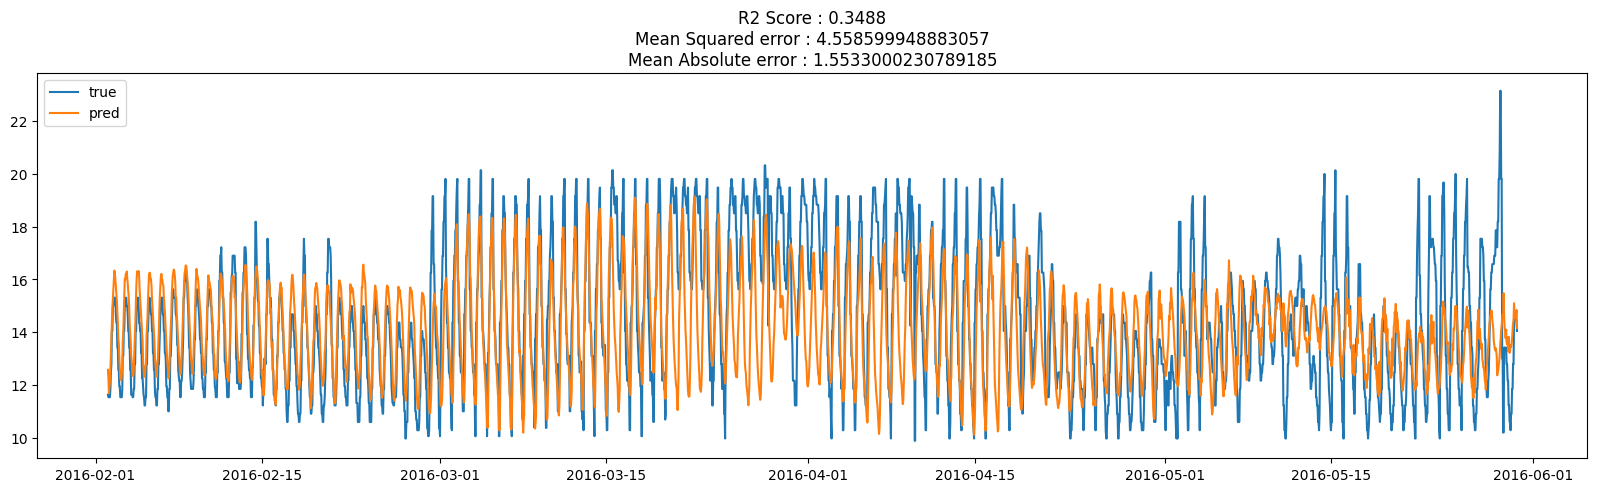

In [10]:
# 测试结果
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
print(preds.shape,trues.shape)
col = 2
test_time_show = df_time[border1s[2]:border1s[2]+preds.shape[0]]
df_show = pd.DataFrame(preds[:,-1,col],columns=['pred'],index=pd.DatetimeIndex(test_time_show))
df_show['true'] = trues[:,-1,col]
df_show['error'] = trues[:,-1,col]-preds[:,-1,col]
plt.figure(figsize=(20,5))
# plt.plot(trues[:,-1,0], label='GroundTruth')
# plt.plot(preds[:,-1,0], label='Prediction')
plt.plot(df_show[['true','pred']])
plt.legend(['true','pred'])
r2=np.round(r2_score(df_show['true'],df_show['pred']),4)
mse=np.round(mean_squared_error(df_show['true'],df_show['pred']),4)
mae=np.round(mean_absolute_error(df_show['true'],df_show['pred']),4)
print(np.array([df_show['true'].array]))
plt.title('R2 Score : {}'.format(r2)+'\n'+'Mean Squared error : {}'.format(mse)+'\n'+'Mean Absolute error : {}'.format(mae))
plt.show()

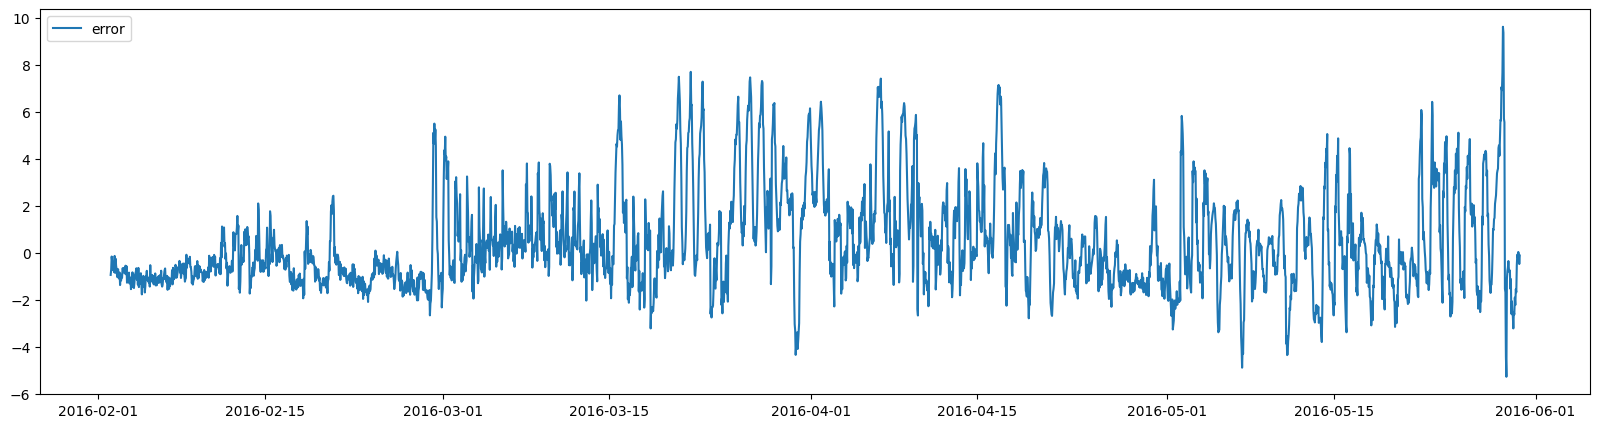

In [11]:
# 误差曲线
plt.figure(figsize=(20,5))
plt.plot(df_show[['error']])
plt.legend(['error'])

### 分段预测评估

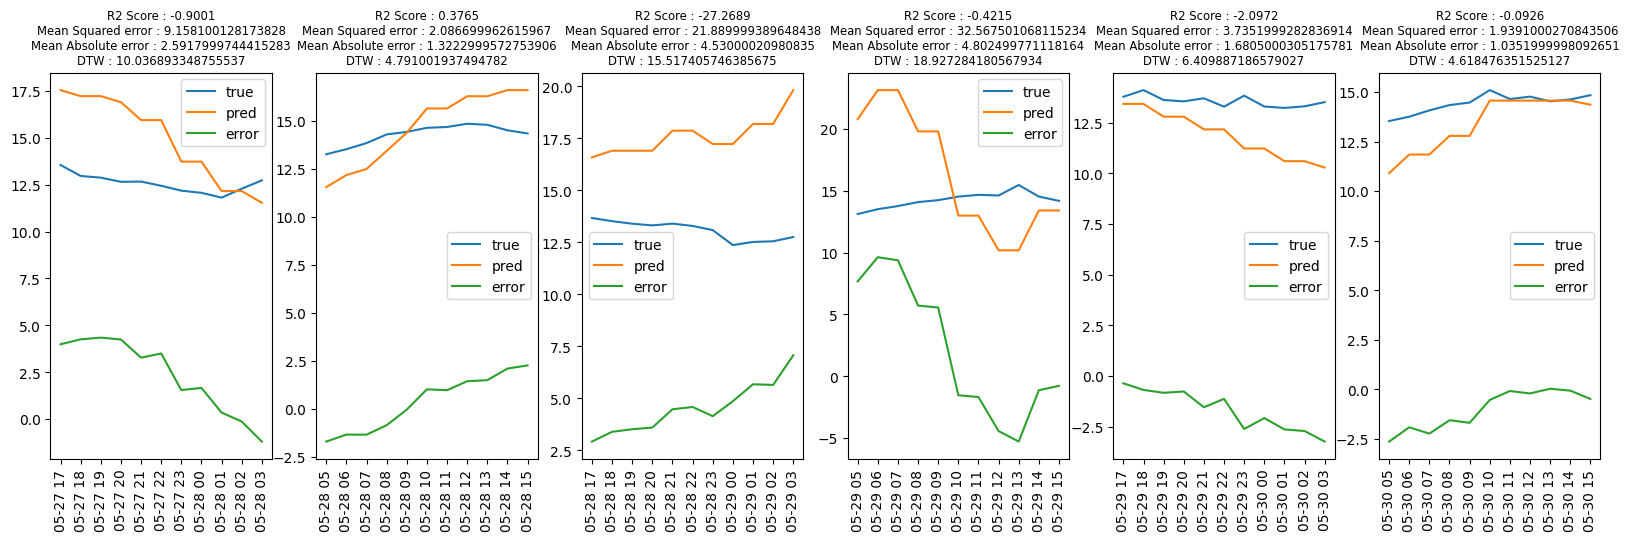

In [14]:
# 分节评估
plotsize = 240
row = 40
plt.figure(figsize=(20,row*6))
for i in range(234,240):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    plt.subplot(row,int(plotsize/row),i+1)
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    # plt.plot(df_show_sub[['true','pred']])
    plt.plot(df_show_sub)
    plt.legend(['true','pred','error'])
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    # dtw = mae
    dtw,_ = fastdtw(np.array([df_show_sub['true'].array]),np.array([df_show_sub['pred'].array]), dist=euclidean)
    plt.title('R2 Score : {}'.format(r2)+'\n'+'Mean Squared error : {}'.format(mse)+'\n'+'Mean Absolute error : {}'.format(mae)+'\n'+'DTW : {}'.format(dtw),fontsize='small')
    plt.xticks(rotation = 90)
plt.show()

2848
[0, 31]
[32, 63]
[64, 95]
[96, 127]
[128, 159]
[160, 191]
[192, 223]
[224, 255]
[256, 287]
[288, 319]
[320, 351]
[352, 383]
[384, 415]
[416, 447]
[448, 479]
[480, 511]
[512, 543]
[544, 575]
[576, 607]
[608, 639]
[640, 671]
[672, 703]
[704, 735]
[736, 767]
[768, 799]
[800, 831]
[832, 863]
[864, 895]
[896, 927]
[928, 959]
[960, 991]
[992, 1023]
[1024, 1055]
[1056, 1087]
[1088, 1119]
[1120, 1151]
[1152, 1183]
[1184, 1215]
[1216, 1247]
[1248, 1279]
[1280, 1311]
[1312, 1343]
[1344, 1375]
[1376, 1407]
[1408, 1439]
[1440, 1471]
[1472, 1502]
[1503, 1535]
[1536, 1567]
[1568, 1599]
[1600, 1630]
[1631, 1663]
[1664, 1695]
[1696, 1727]
[1728, 1758]
[1759, 1791]
[1792, 1823]
[1824, 1855]
[1856, 1886]
[1887, 1919]
[1920, 1951]
[1952, 1983]
[1984, 2014]
[2015, 2047]
[2048, 2079]
[2080, 2111]
[2112, 2143]
[2144, 2175]
[2176, 2207]
[2208, 2239]
[2240, 2271]
[2272, 2303]
[2304, 2335]
[2336, 2367]
[2368, 2399]
[2400, 2431]
[2432, 2463]
[2464, 2495]
[2496, 2527]
[2528, 2559]
[2560, 2591]
[2592, 2623]


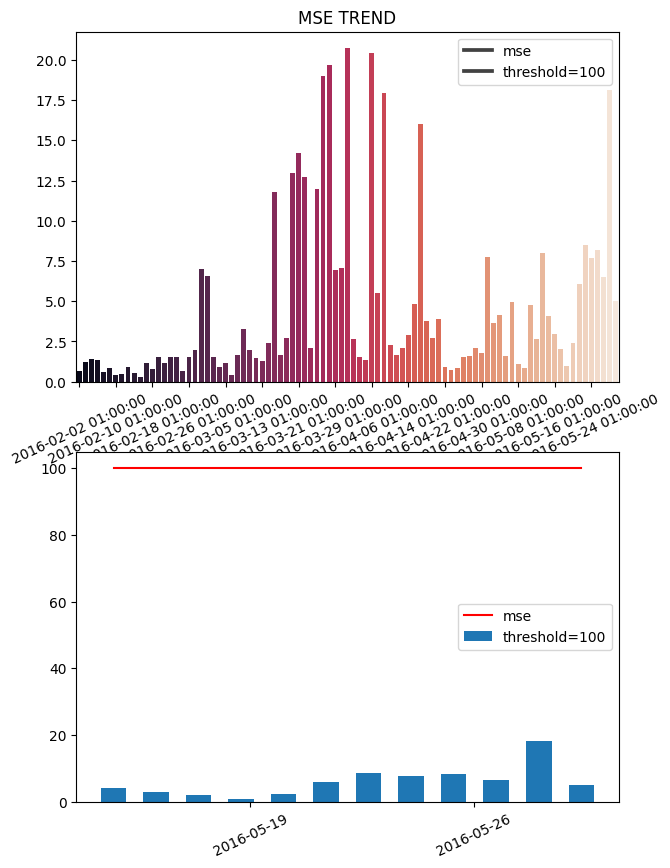

In [15]:
# mse曲线
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
plotsize = 89
mselist = []
time_mse_list = []
threshold=100
print(len(df_show))
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    print(plotindex)
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    dtw,_ = fastdtw(np.array([df_show_sub['true'].array]),np.array([df_show_sub['pred'].array]), dist=euclidean)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mse)
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.title('MSE TREND')
# plt.plot(time_mse_list,mselist,'.',linewidth=5)
# plt.scatter(time_mse_list,mselist,s=3)
# plt.bar(time_mse_list,mselist)

ax = sns.barplot(x=time_mse_list,y=mselist,palette="rocket")
plt.xticks(rotation = 25)
# plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)
# ax.set_xticks(ticks=list(range(0,len(time_mse_list),6)))
xlocator = MultipleLocator(6)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(xlocator)
plt.subplot(2,1,2)
# plt.plot(time_mse_list[-12::],mselist[-12::],'.')
plt.bar(time_mse_list[-12::],mselist[-12::])
plt.plot([time_mse_list[-12],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)
xlocator = MultipleLocator(7)
ax2 = plt.gca()
ax2.xaxis.set_major_locator(xlocator)




2848
[0, 1]
[2, 4]
[5, 6]
[7, 9]
[10, 11]
[12, 14]
[15, 17]
[18, 19]
[20, 22]
[23, 24]
[25, 27]
[28, 30]
[31, 32]
[33, 35]
[36, 37]
[38, 40]
[41, 43]
[44, 45]
[46, 48]
[49, 50]
[51, 53]
[54, 55]
[56, 58]
[59, 61]
[62, 63]
[64, 66]
[67, 68]
[69, 71]
[72, 74]
[75, 76]
[77, 79]
[80, 81]
[82, 84]
[85, 87]
[88, 89]
[90, 92]
[93, 94]
[95, 97]
[98, 99]
[100, 102]
[103, 105]
[106, 107]
[108, 110]
[111, 112]
[113, 115]
[116, 118]
[119, 120]
[121, 123]
[124, 125]
[126, 128]
[129, 131]
[132, 133]
[134, 136]
[137, 138]
[139, 141]
[142, 143]
[144, 146]
[147, 149]
[150, 151]
[152, 154]
[155, 156]
[157, 159]
[160, 162]
[163, 164]
[165, 167]
[168, 169]
[170, 172]
[173, 175]
[176, 177]
[178, 180]
[181, 182]
[183, 185]
[186, 188]
[189, 190]
[191, 193]
[194, 195]
[196, 198]
[199, 200]
[201, 203]
[204, 206]
[207, 208]
[209, 211]
[212, 213]
[214, 216]
[217, 219]
[220, 221]
[222, 224]
[225, 226]
[227, 229]
[230, 232]
[233, 234]
[235, 237]
[238, 239]
[240, 242]
[243, 244]
[245, 247]
[248, 250]
[251, 252]
[25

(array([16832., 16846., 16861., 16875., 16892., 16906., 16922., 16936.,
        16953.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

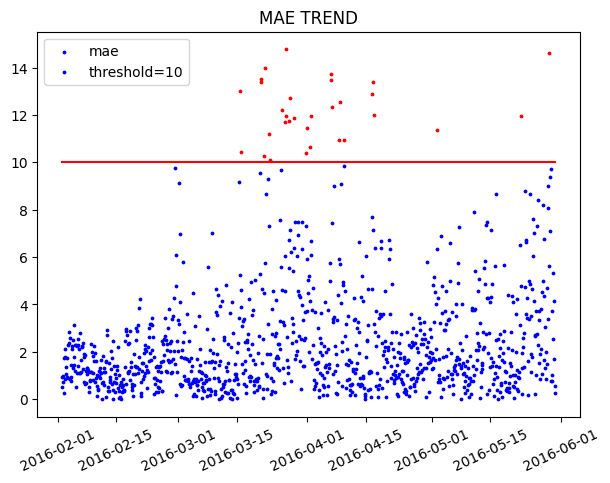

In [16]:
# mse散点
plotsize = 1100
mselist = []
time_mse_list = []
threshold=10
print(len(df_show))
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    print(plotindex)
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    dtw,_ = fastdtw(np.array([df_show_sub['true'].array]),np.array([df_show_sub['pred'].array]), dist=euclidean)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mae*(int((i+1)/plotsize*len(df_show))-1-int(i/plotsize*len(df_show))))
plt.figure(figsize=(7,5))
plt.title('MAE TREND')
# plt.plot(time_mse_list,mselist,'.',linewidth=5)
for i in range(len(time_mse_list)):
    if mselist[i]>10:
        plt.scatter(time_mse_list[i],mselist[i],s=3,c='r')
    if mselist[i]<=10:
        plt.scatter(time_mse_list[i],mselist[i],s=3,c='b')
plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-',c='r')
plt.legend(['mae','threshold='+str(threshold)])
plt.xticks(rotation = 25)


2848
[0, 31]
[32, 63]
[64, 95]
[96, 127]
[128, 159]
[160, 191]
[192, 223]
[224, 255]
[256, 287]
[288, 319]
[320, 351]
[352, 383]
[384, 415]
[416, 447]
[448, 479]
[480, 511]
[512, 543]
[544, 575]
[576, 607]
[608, 639]
[640, 671]
[672, 703]
[704, 735]
[736, 767]
[768, 799]
[800, 831]
[832, 863]
[864, 895]
[896, 927]
[928, 959]
[960, 991]
[992, 1023]
[1024, 1055]
[1056, 1087]
[1088, 1119]
[1120, 1151]
[1152, 1183]
[1184, 1215]
[1216, 1247]
[1248, 1279]
[1280, 1311]
[1312, 1343]
[1344, 1375]
[1376, 1407]
[1408, 1439]
[1440, 1471]
[1472, 1502]
[1503, 1535]
[1536, 1567]
[1568, 1599]
[1600, 1630]
[1631, 1663]
[1664, 1695]
[1696, 1727]
[1728, 1758]
[1759, 1791]
[1792, 1823]
[1824, 1855]
[1856, 1886]
[1887, 1919]
[1920, 1951]
[1952, 1983]
[1984, 2014]
[2015, 2047]
[2048, 2079]
[2080, 2111]
[2112, 2143]
[2144, 2175]
[2176, 2207]
[2208, 2239]
[2240, 2271]
[2272, 2303]
[2304, 2335]
[2336, 2367]
[2368, 2399]
[2400, 2431]
[2432, 2463]
[2464, 2495]
[2496, 2527]
[2528, 2559]
[2560, 2591]
[2592, 2623]


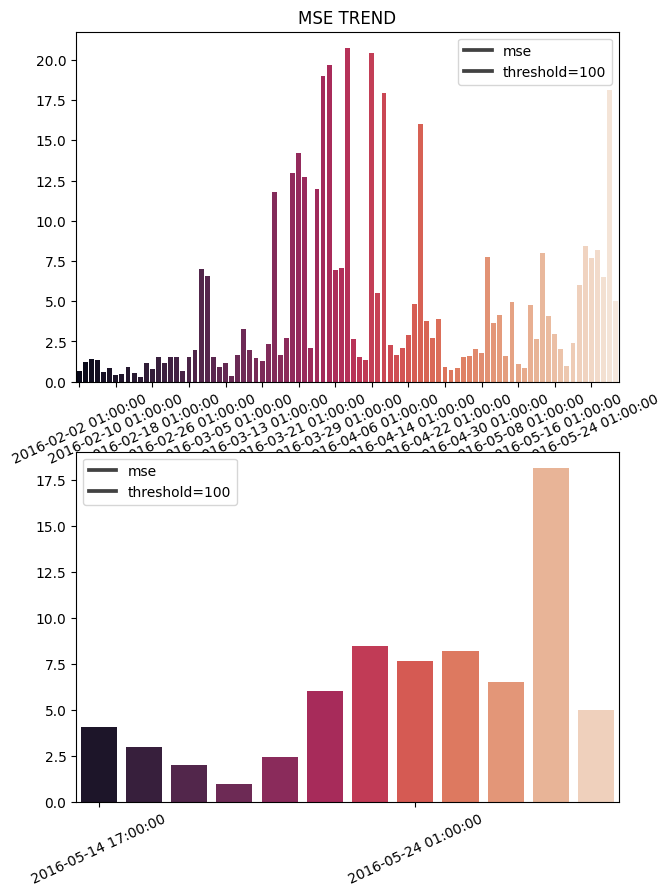

In [17]:
# mse曲线
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
plotsize = 89
mselist = []
time_mse_list = []
threshold=100
print(len(df_show))
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    print(plotindex)
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    dtw,_ = fastdtw(np.array([df_show_sub['true'].array]),np.array([df_show_sub['pred'].array]), dist=euclidean)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mse)
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.title('MSE TREND')
# plt.plot(time_mse_list,mselist,'.',linewidth=5)
# plt.scatter(time_mse_list,mselist,s=3)
# plt.bar(time_mse_list,mselist)

ax = sns.barplot(x=time_mse_list,y=mselist,palette="rocket")
plt.xticks(rotation = 25)
# plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)
# ax.set_xticks(ticks=list(range(0,len(time_mse_list),6)))
xlocator = MultipleLocator(6)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(xlocator)
plt.subplot(2,1,2)
# plt.plot(time_mse_list[-12::],mselist[-12::],'.')
# plt.bar(time_mse_list[-12::],mselist[-12::])
ax = sns.barplot(x=time_mse_list[-12::],y=mselist[-12::],palette="rocket")
# plt.plot([time_mse_list[-12],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)
xlocator = MultipleLocator(7)
ax2 = plt.gca()
ax2.xaxis.set_major_locator(xlocator)


(array([16950.16666667, 16950.33333333, 16950.5       , 16950.66666667,
        16950.83333333, 16951.        , 16951.16666667, 16951.33333333,
        16951.5       ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

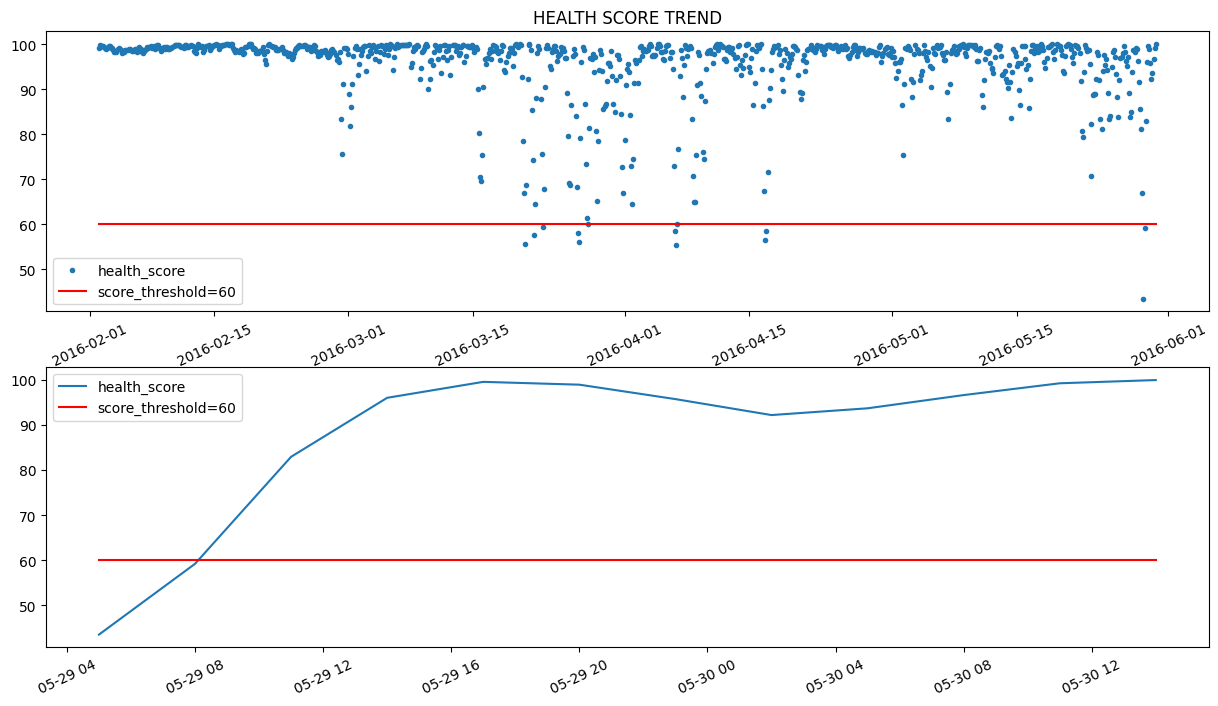

In [18]:
# 健康评分函数
import math
# 加权平均，健康分数应当与上一时刻有关
def weighted_mean(list,alpha=0.3):
    mean_list = []
    for i in range(len(list)):
        if i==0:
            mean_list.append(list[i])
        if i>0:
            mean_list.append(list[i]*(1-alpha)+list[i-1]*alpha)
    return mean_list
# 健康分数
def health_score(mselist,k=0.01):
    score_list = []
    for mse in mselist:
        score = 100-100*(math.tanh(k*mse))
        score_list.append(score)
    return score_list

# 健康评分曲线
plotsize = 960
mselist = []
r2list = []
time_mse_list = []
threshold=60
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mse)
score_list = weighted_mean(health_score(mselist))
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title('HEALTH SCORE TREND')
plt.plot(time_mse_list,score_list,'.')
plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['health_score','score_threshold='+str(threshold)])
plt.xticks(rotation = 25)
plt.subplot(2,1,2)
plt.plot(time_mse_list[-12::],score_list[-12::])
plt.plot([time_mse_list[-12],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['health_score','score_threshold='+str(threshold)])
plt.xticks(rotation = 25)